In [30]:
import numpy as np 
from scipy.sparse import dok_matrix, vstack, csr_matrix
from snorkel.labeling import PandasLFApplier, LFApplier, LFAnalysis, labeling_function
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [31]:
sents = []
iob_tags = []
text = ""
# filename = './conll2003/train_tokens.txt'
filename = './re3d/train.txt'

with open(filename, 'r') as file:
    lst = []
    while True:
        word_lst = file.readline().lower().split("\t")
        word = word_lst[0]
        if not word:
            break
        text += " " + word

        if word == '\n':
            sents.append(lst)
            lst = []
        else:
            lst.append(word)
            iob_tags.append(word_lst[-1].split('\n')[0])

    sents.append(lst)

### Distinct Types of IOB Tokens

In [32]:
dist = set()
for tok in iob_tags:
    dist.add(tok)

print(dist)

{'b-money', 'i-nationality', 'i-organisation', 'b-documentreference', 'i-money', 'i-temporal', 'b-location', 'i-documentreference', 'i-quantity', 'b-person', 'i-weapon', 'b-nationality', 'b-organisation', 'b-militaryplatform', 'i-person', 'b-quantity', 'i-location', 'b-temporal', 'i-militaryplatform', 'b-weapon', 'o'}


In [33]:
# Here we are checking and ensuring that both number of tokens in sentences and number of tags in iob_tags are same
print('Number of iob tags are: ',len(iob_tags))

l=0
for i in range(len(sents)):
    l+=len(sents[i])

print('Number of tokens are: ',l)

Number of iob tags are:  20030
Number of tokens are:  20030


In [34]:
print(sents[6])

['but', 'nobody', 'can', 'leave', 'now', '.']


In [35]:
# converting iob tags to numerical tags
o = 0
b_org = 1
i_org = 2
b_quan = 3
i_quan = 4
b_weapon = 5
i_weapon = 6
b_doc = 7
i_doc = 8
b_person = 9
i_person = 10
b_nationality = 11
i_nationality = 12
b_money = 13
i_money = 14
b_temporal = 15
i_temporal = 16
b_loc = 17
i_loc = 18
b_milplat = 19
i_milplat = 20



iob_dict = {
    "o" : 0,
    "b-organisation" : 1,
    "i-organisation" : 2,
    "b-quantity" : 3,
    "i-quantity" : 4,
    "b-weapon" : 5,
    "i-weapon" : 6,
    "b-documentreference" : 7,
    "i-documentreference" : 8,
    "b-person" : 9,
    "i-person" : 10,
    "b-nationality" : 11,
    "i-nationality" : 12,
    "b-money" : 13,
    "i-money" : 14,
    "b-temporal" : 15,
    "i-temporal" : 16,
    "b-location" : 17,
    "i-location" : 18,
    "b-militaryplatform" : 19,
    "i-militaryplatform" : 20,
}

num_iob_tags = []
for tok in iob_tags:
    num_iob_tags.append(iob_dict[tok])

num_iob_tags = np.array(num_iob_tags)

In [36]:
# labeling functions
def moneyLF(x):
   i_lst = ['dinar','dinars','dollars','million','millions','donor','jordanian','billion','billions']
   b_lst = ['$','£','wage','wages','salaries','money']

   sent_dict = {}
   for i in range(len(x)):
      if x[i] in i_lst:
         sent_dict[i] = i_money
      if x[i] in b_lst:
         sent_dict[i] = b_money

   for i in range(len(x)):
      if i+1< len(x) and sent_dict.get(i) != None and sent_dict[i] == b_money and sent_dict.get(i+1)==None:
         sent_dict[i+1] = i_money

      if i-1 >=0 and sent_dict.get(i) != None and sent_dict[i] == i_money and sent_dict.get(i-1)==None:
         sent_dict[i-1] = b_money  

   return sent_dict      



def quantityLF(x):
   i_lst = ['percent','miles','domains','million','millions','thousand','thousands','km','kms','mi','square','squares','m3','acre','acres','%','beds','plus','kilometers','kilometer']

   sent_dict = {}
   for i in range(len(x)):
      if x[i] in i_lst:
         sent_dict[i] = i_quan

   for i in range(len(x)):
      if i-1 >=0 and sent_dict.get(i) != None and sent_dict[i] == i_quan and sent_dict.get(i-1)==None:
         sent_dict[i-1] = b_quan 

   return sent_dict 

# document reference LF
def docLF(x):
   i_lst = ['book','books','chapter','resolution','text','texts','report','reports']
   b_lst = ['constitution','un','united nation','united nations','executive','executives']

   sent_dict = {}
   for i in range(len(x)):
      if x[i] in i_lst:
         sent_dict[i] = i_doc
      if x[i] in b_lst:
         sent_dict[i] = b_doc

   for i in range(len(x)):
      if i+1< len(x) and sent_dict.get(i) != None and sent_dict[i] == b_doc and sent_dict.get(i+1)==None:
         sent_dict[i+1] = i_doc

      if i-1 >=0 and sent_dict.get(i) != None and sent_dict[i] == i_doc and sent_dict.get(i-1)==None:
         sent_dict[i-1] = b_doc 

   return sent_dict      

def locLF(x):
   b_lst = ['in', 'near', 'above', 'over', 'by', 'along', 'around']

   sent_dict = {}
   for i in range(len(x)):
      if x[i] in b_lst:
         sent_dict[i] = b_loc
         if i+1<len(x):
            sent_dict[i+1] = i_loc

   return sent_dict

def keywordMatching(s, words_list, iTAG, bTAG):
   new_list = []
   label_dict = dict()
   for word in words_list:
      new_list.append(word.lower())

   for i, word in enumerate(s):
      if word in new_list:
         if i > 0 and i-1 in label_dict and label_dict[i-1] == iTAG:
               label_dict[i] = iTAG
         else:
               label_dict[i] = bTAG
   return label_dict

def weaponLF(s):
   label_dict = dict()
   weapon_words_list = ['weapons','strikes','chemical','rocket','artillery','munitions','strike','VBIED','gun','mortar','propelled','heavy',
                            'machine','VBIEDs','bombs','grenade','missile','bomb','barrel','launcher','front','end','weapon','systems','IED']
   return keywordMatching(s, weapon_words_list, i_weapon, b_weapon)


def nationalityLF(s):
   label_dict = dict()
   nationality_words_list =['Syrian','Iraqi','Kurdish','Yazidi','Arabic','Australian','Shia','Arab',
                        'Islam','Shiite','German','Jordan','Israeli','Muslims','Yazidis','Kurmanji','Northern']
   return keywordMatching(s, nationality_words_list, i_nationality, b_nationality)

def orgLF(s):
   org_words_list = ['forces', 'Iraq', 'Syrian', 'Coalition', 'United', 'people', 'Iraqi', 'group', 'government', 'regime', 'tactical', 'Forces', 'States', 'Government', 'international', 'Security', 'coalition', 'partners', 'Council', 'UN', 'ISIL', 'military', 'fighters', 'State', 'Department', 'units', 'UK', 'esh', 'community', 'U.S.', 'Command', 'civilians', 'security', 'parties', 'members', 'Force', 'unit', 'SDF', 'terrorist', 'victims', 'officials', 'Arab', 'terrorists', 'leaders', 'Central', 'residents', 'Levant', 'allies', 'Democratic', 'opposition', 'Army', 'families', 'Assad', 'family', 'two', 'Asad', 'Iraqis', 'Islamic', 'Joint', 'Union', 'Qaida', 'Nations', 'Syria', 'Group', 'Members', 'Air', 'Battalion', 'officers', 'organization', 'Marines', 'enemy', 'Task', 'EU', 'women', 'nations', 'friends', 'European', 'Syrians', 'countries']
   return keywordMatching(s, org_words_list, i_org, b_org)  

def temporalLF(s):
   temporal_words_list = ['year', 'hours', 'days', 'December', 'years', '2006', 'week', '2016', 'November', 'past', 'last', 'day', 'months', 'Thanksgiving', 'Dec.', '15', '13', 'weeks', '2005', 'ago', 'Day', 'night', '26', 'end', '27', 'February', '2015', 'four', 'morning', '6', '10', '19', 'following', '2007', '7', 'festive', 'just', 'before', 'Muslim', 'Eid', 'celebration', '14th', 'later', '3', 'Z', 'Time', '2008', 'Sunday', 'May', '88', '91', 'first', 'long', '1979', 'January', 'eve', 'a', 'New', 'Year', '2013', 'month', 'a.m.', '29', '5', '1', '16', '18', 'coming', 'and', '2014', 'two', 'March', 'three', 'attack', 'minutes', 'June', 'from', 'late', 'to', 'early', 'evening', 'September', '20', 'plus', '6th', '7th', '25', '2011', 'summer', '2017', 'on', 'Thursday', '28', 'July', '2009', 'weekend', 'August', 'in', 'or', 'seven']
   return keywordMatching(s, temporal_words_list, i_temporal, b_temporal)   

def personLF(x):
   return {}

def militaryplatformLF(x):
   return {}

lfs = [
   moneyLF,
   quantityLF,
   locLF,
   nationalityLF,
   weaponLF,
   docLF,
   orgLF,
   temporalLF,
   personLF,
   militaryplatformLF
]

# apply labeling functions and transform label matrix 
labels = [[lf(s) for lf in lfs] for s in sents] 

# creating dense matrix
n = 0
for s in sents:
    n+=len(s)
m = len(lfs)
mat = np.zeros((n,m))
row = 0
for i in range(len(labels)):
    for col,dic in enumerate(labels[i]):
        for key in dic:
            mat[row+key][col] = dic[key]

    row += len(sents[i])

In [37]:
# increase the epochs
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=20, verbose=True)
label_model.fit(L_train=mat, n_epochs=1000, log_freq=100, seed=123)
y_pred = label_model.predict(mat)

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 1000/1000 [00:03<00:00, 286.62epoch/s]
INFO:root:Finished Training


In [38]:
# finding accuracy
label_model_acc = label_model.score(L=mat, Y=num_iob_tags, tie_break_policy="random")["accuracy"]
print('Accuracy of Weak Supervision approach is: ',label_model_acc)

Accuracy of Weak Supervision approach is:  0.6502246630054918


In [43]:
# classification report
target_names = ["o","b-organisation","i-organisation","b-quantity","i-quantity","b-weapon","i-weapon","b-documentreference","i-documentreference","b-person","i-person","b-nationality","i-nationality","b-money","i-money","b-temporal","i-temporal","b-location","i-location","b-militaryplatform","i-militaryplatform"]
print(classification_report(num_iob_tags, y_pred, target_names=target_names, zero_division=1))

                     precision    recall  f1-score   support

                  o       0.73      0.92      0.82     13747
     b-organisation       0.18      0.24      0.21      1104
     i-organisation       1.00      0.00      0.00      1539
         b-quantity       0.35      0.04      0.07       150
         i-quantity       0.84      0.22      0.35        94
           b-weapon       1.00      0.00      0.00        81
           i-weapon       1.00      0.00      0.00        70
b-documentreference       0.20      0.20      0.20        50
i-documentreference       1.00      0.00      0.00       146
           b-person       1.00      0.00      0.00       411
           i-person       1.00      0.00      0.00       605
      b-nationality       0.25      0.41      0.31        34
      i-nationality       1.00      0.00      0.00         2
            b-money       0.44      0.55      0.49        20
            i-money       0.38      0.22      0.28        36
         b-temporal    

In [40]:
print('Cumulative F1 Score: ',f1_score(num_iob_tags, y_pred, average='weighted'))

Cumulative F1 Score:  0.5764331610174356


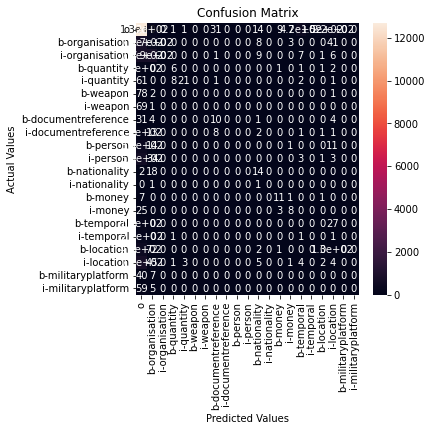

In [42]:
# Confusion Matrix
cm = confusion_matrix(num_iob_tags, y_pred)
cm_df = pd.DataFrame(cm,index = target_names, columns = target_names)

#Plotting the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [29]:
# snorkel labelled data
iob_dict_reverse = {
    0: "o",
    1:"b-organisation",
    2:"i-organisation",
    3:"b-quantity",
    4:"i-quantity",
    5:"b-weapon",
    6:"i-weapon",
    7:"b-documentreference",
    8:"i-documentreference",
    9:"b-person",
    10:"i-person",
    11:"b-nationality",
    12:"i-nationality",
    13:"b-money",
    14:"i-money",
    15:"b-temporal",
    16:"i-temporal",
    17:"b-location",
    18:"i-location",
    19:"b-militaryplatform",
    20:"i-militaryplatform"
}

str = ''
cnt = 0
for sen in sents:
    for i in range(len(sen)):
        str += sen[i]
        str += '\t'
        str += iob_dict_reverse[y_pred[cnt]]
        str += '\n'
        cnt += 1

    str += '\n'


f = open('./re3d/snorkel_labelled_25k.txt','w')
f.write(str)
f.close()